In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
import json
import h5py
from utils import img_data_2_mini_batch, imgs2batch
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as Data
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import os


%matplotlib inline
%reload_ext autoreload

In [4]:
base_f = 'cocoqa_data_prepro_'
base_n = '46'
base_fn = base_f + base_n




transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])


In [5]:
val_data_h5 = h5py.File(base_fn+'.h5', 'r')

In [6]:

val_data_json = json.load(open(base_fn+'.json', 'r'))
# pad fix
itow = val_data_json['ix_to_word']

wtoi = {iv: ik for ik,iv in itow.items()}
old_pad = wtoi['<pad>']
wtoi['<pad_fix>'] = old_pad
wtoi['<pad>'] = '0'
itow[old_pad] = '<pad_fix>'
itow['0'] = '<pad>'

# print wtoi['<pad>']
# print itow['0']
# print wtoi['<pad_fix>']

assert(wtoi['<pad>'] == '0')
assert(itow['0'] == '<pad>')


# print val_data_json.keys()
# print val_data_h5.keys()

In [7]:
itoa = val_data_json['ix_to_ans']
# print len(itoa)
# print itoa['38']
# print itoa
unique_img_val = val_data_json['unique_img_val']
ques_val = val_data_h5['ques_val'][:]
ans_val = val_data_h5['ans_val'][:]
question_id_val = val_data_h5['question_id_val'][:]
img_pos_val = val_data_h5['img_pos_val'][:]
images = np.array(imgs2batch(unique_img_val, img_pos_val, transform=transform))
ques_val = np.array(ques_val)
ans_val = np.array(ans_val).reshape((-1, 1))

# print images.shape

images = torch.from_numpy(images)
ques_val = torch.from_numpy(ques_val)
ans_val = torch.from_numpy(ans_val)

# print images.size()
# print ques_val.size()
# print ans_val.size()
# print(ans_val.shape)


In [8]:
# for i in range(ques_val.size(1)):
#     print ' '.join(filter(lambda kx: kx!='<pad>',(map(lambda wr: itow[str(wr)], ques_val[i].detach().numpy().tolist()))))
#     print ' '.join(map(lambda wr: itoa[str(wr)], ans_val[i].detach().numpy().tolist()))


In [54]:
ques_ans_val = torch.cat((ques_val, ans_val), dim=1)
BATCH_SIZE = 20
dataset=Data.TensorDataset(images, ques_ans_val)
# img, abc = dataset[0]
# print img.shape
# plt.figure()
# plt.imshow(img.reshape((224,2,3)))

train_loader = Data.DataLoader(
        dataset=dataset,
        batch_size=BATCH_SIZE,
        shuffle=True
    )


In [19]:
from naive import Enc, Dec
device = torch.device('cuda')
embed_size = 128
hidden_size = 128
ques_vocab_size = len(itow)
ans_vocab_size = len(itoa)+1
num_layers = 1



# Build models
encoder = Enc(embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder = Dec(embed_size, hidden_size, ques_vocab_size, ans_vocab_size, num_layers)
encoder = encoder.to(device)
decoder = decoder.to(device)

# Load the trained model parameters
encoder.load_state_dict(torch.load("encoder_93.ckpt"))
decoder.load_state_dict(torch.load("decoder_93.ckpt"))




RuntimeError: Error(s) in loading state_dict for Dec:
	size mismatch for embed.weight: copying a param with shape torch.Size([212, 128]) from checkpoint, the shape in current model is torch.Size([122, 128]).
	size mismatch for linear.weight: copying a param with shape torch.Size([39, 128]) from checkpoint, the shape in current model is torch.Size([27, 128]).
	size mismatch for linear.bias: copying a param with shape torch.Size([39]) from checkpoint, the shape in current model is torch.Size([27]).

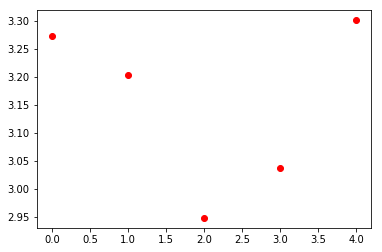

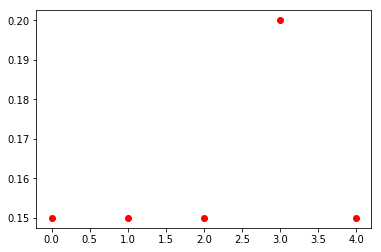

In [46]:
plt.figure()
plt.plot(range(len(lossList)), lossList, 'ro')
plt.show()

plt.figure()
plt.plot(range(len(accList)), accList, 'ro')
plt.show()